In [ ]:

import nibabel as nib
import pandas as pd
import os
import numpy as np
import os
import zipfile
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage



def read_nifti_image_file(file_path):
    """Read and load volume"""
    # Read file
    scan = nib.load(file_path)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_vol(img):
    """Resize across z-axis"""
    # Set the desired depth
    img_desired_depth = 64
    img_desired_width = 128
    img_desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / img_desired_depth
    width = current_width / img_desired_width
    height = current_height / img_desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def scan_process(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_image_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_vol(volume)
    return volume


In [ ]:
labels_dataframe = pd.read_csv('C:/Users/shrad/OneDrive/Desktop/BET_BSE_DATA (1)/BET_BSE_DATA/Label_file.csv')

In [ ]:
labels_dataframe

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,Yes,No
1,IXI448-HH-2393-T1_bet_07.nii,Yes,No
2,IXI252-HH-1693-T1_bet_08.nii,Yes,No
3,IXI188-Guys-0798-T1_bet_17.nii,Yes,No
4,IXI182-Guys-0792-T1_bet_17.nii,Yes,No
...,...,...,...
1306,IXI477-IOP-1141-T1_bse_default.nii,Yes,No
1307,IXI573-IOP-1155-T1_bse_default.nii,Yes,No
1308,IXI483-HH-2177-T1_bse_default.nii,No,Yes
1309,IXI159-HH-1549-T1_bse_default.nii,Yes,No


In [ ]:
files_location = os.listdir('C:/Users/shrad/OneDrive/Desktop/BET_BSE_DATA (1)/BET_BSE_DATA/files')

In [ ]:
labels_files = []
for k in files_location:
    labels_files.append(labels_dataframe[labels_dataframe['Filename'] == k.strip('.gz')]['Recognizable-Facial-Feature'].values[0])

In [ ]:
normal_scan_paths = ['C:/Users/shrad/OneDrive/Desktop/BET_BSE_DATA (1)/BET_BSE_DATA/files/' + l for l in files_location]

In [ ]:
len(normal_scan_paths)

1311

In [ ]:
normal_scans = np.array([scan_process(path) for path in normal_scan_paths])

In [ ]:
labels = [1 if g == 'Yes' else 0 for g in labels_files]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(normal_scans, labels, test_size=0.33, random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [ ]:
len(X_train)

878

In [ ]:
!pip install tensorflow

In [ ]:


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    aug_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return aug_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [ ]:
#enter the train test split cell here and rename the variable in train loader and validation loader
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
learning_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_schedule),
    metrics=["acc" , tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.FalseNegatives()],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 5
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
307/307 - 3059s - loss: 0.4031 - acc: 0.7752 - mean_squared_error: 0.1342 - auc: 0.8878 - recall: 0.7938 - true_positives: 258.0000 - false_negatives: 67.0000 - val_loss: 0.1660 - val_acc: 0.9848 - val_mean_squared_error: 0.0333 - val_auc: 0.9904 - val_recall: 0.9927 - val_true_positives: 136.0000 - val_false_negatives: 1.0000 - 3059s/epoch - 10s/step
Epoch 2/5
307/307 - 3592s - loss: 0.2750 - acc: 0.8681 - mean_squared_error: 0.0862 - auc: 0.9551 - recall: 0.8708 - true_positives: 283.0000 - false_negatives: 42.0000 - val_loss: 1.3134 - val_acc: 0.5530 - val_mean_squared_error: 0.3656 - val_auc: 0.9889 - val_recall: 1.0000 - val_true_positives: 137.0000 - val_false_negatives: 0.0000e+00 - 3592s/epoch - 12s/step
Epoch 3/5
307/307 - 3732s - loss: 0.2529 - acc: 0.8860 - mean_squared_error: 0.0804 - auc: 0.9639 - recall: 0.9108 - true_positives: 296.0000 - false_negatives: 29.0000 - val_loss: 0.1213 - val_acc: 0.9886 - val_mean_squared_error: 0.0183 - val_auc: 0.9862 - val_recal

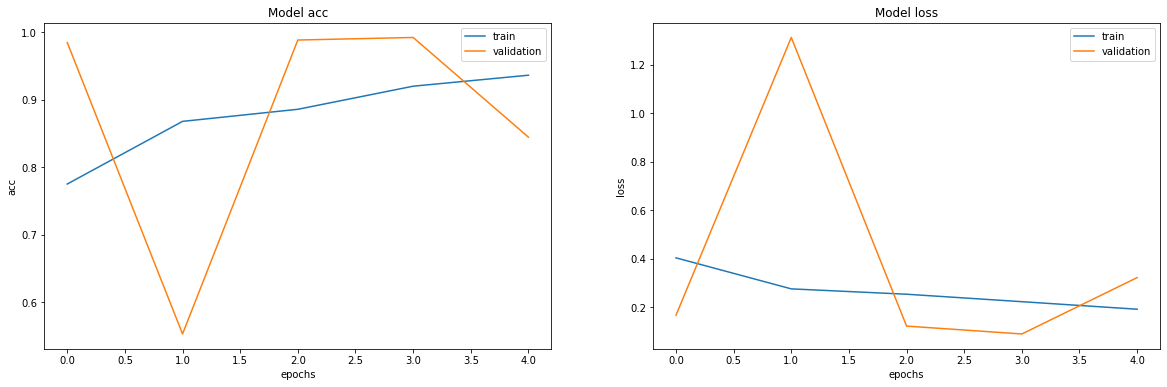

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "validation"])

In [ ]:
model.load_weights("3d_image_classification.h5")
new_list=[]
for i in range(len(X_test)):
    prediction = model.predict(np.expand_dims(X_test[i], axis=0))[0] 
    scores = [1 - prediction[0], prediction[0]]
    new_list.append([prediction[0]])



In [ ]:
new_list

[[0.9913066],
 [0.9980204],
 [0.009150445],
 [0.05409625],
 [0.91249955],
 [0.0014264882],
 [0.9999839],
 [0.9998077],
 [0.99979997],
 [0.9999328],
 [0.9995378],
 [0.001980573],
 [0.066853344],
 [0.99993527],
 [0.9999967],
 [0.99953675],
 [0.99991775],
 [0.0028820336],
 [0.0042727888],
 [9.93587e-05],
 [0.0043786466],
 [0.0071914196],
 [0.012381762],
 [0.02715242],
 [0.99973446],
 [0.107196],
 [0.99521554],
 [0.09901205],
 [0.03300336],
 [0.9998808],
 [0.9998879],
 [0.00034338236],
 [0.0039551556],
 [0.0922229],
 [0.9977334],
 [0.017012775],
 [0.07740638],
 [0.03752774],
 [0.1347005],
 [0.058734298],
 [0.05568117],
 [0.9999422],
 [0.99927473],
 [0.99989367],
 [0.041125387],
 [0.99833524],
 [0.9990336],
 [0.9992454],
 [0.01443553],
 [0.0006174147],
 [0.15687251],
 [0.0017774701],
 [0.124812305],
 [0.9999137],
 [0.99966085],
 [0.0017528534],
 [0.9998791],
 [0.9939179],
 [0.18706048],
 [0.99876463],
 [0.0040561557],
 [0.9998711],
 [0.011747569],
 [0.99995923],
 [0.02119124],
 [0.002925574

In [ ]:
test_list=[]
for i in Y_test:
    test_list.append([i])

In [ ]:
test_list

[[1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0]

In [ ]:
[prediction[0]]

[0.017896056]

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()

In [ ]:
m.update_state(test_list, new_list)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=433.0>

In [ ]:
model_accuracy=m.result().numpy()*100

In [ ]:
model_accuracy

98.38337302207947